# Credit Card Fraud Detection

[Anonymized credit card transactions labeled as fraudulent or genuine](https://www.kaggle.com/mlg-ulb/creditcardfraud).

## Config

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from solucao_exemplo_plotting import (plot_confusion_matrix, precision_recall,
                                      multiple_histograms_plot)

from solucao_exemplo_evaluation import predictions_hist

from solucao_exemplo_auto_lgbm import (find_n_estimators, make_param_grids,
                                       grid_search)

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

from sklearn.externals import joblib

In [2]:
%matplotlib inline

In [3]:
# exibe todas as colunas do DataFrame
pd.options.display.max_columns = 35

# deixa de utilizar a notação científica
pd.options.display.float_format = lambda x: '%.6f' % x

In [4]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [5]:
X_train = train.drop(columns='Class')
X_test = test.drop(columns='Class')

y_train = train['Class']
y_test = test['Class']

In [6]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_daytime,Amount_1,Amount_99_99,Amount_0
0,113921,-0.132066,0.107044,-0.650588,-0.996032,1.814333,1.740740,0.496852,0.633016,0.017181,-0.362707,0.527911,0.505396,-0.742107,0.492430,-0.163585,-0.950404,0.262987,-1.760767,-0.939037,-0.062612,-0.062489,0.005292,0.251519,-2.466810,-0.889690,0.337462,0.306395,0.074817,47.890000,0,False,False,False
1,135319,2.125994,0.014207,-1.514760,0.115021,0.598510,-0.333235,0.199289,-0.264353,0.384111,0.028747,-1.208334,0.838156,1.511476,-0.042076,-0.002894,0.080270,-0.658905,-0.747678,0.431762,-0.086076,-0.329368,-0.788150,0.267730,0.066122,-0.135785,0.203841,-0.068267,-0.057678,1.980000,1,False,False,False
2,125498,-0.086694,0.166240,1.573127,0.687266,0.222359,1.102606,1.575093,-1.098608,0.763887,1.404677,1.346697,0.140822,0.159637,-1.147153,0.664997,-0.133032,-1.267675,0.818995,0.405276,0.052960,0.015324,1.063663,-0.410841,0.722723,-0.171733,-0.613543,-1.201571,-1.139931,170.100000,1,False,False,False
3,33520,1.352339,-0.534984,0.555143,-0.629355,-1.144170,-0.852967,-0.642128,-0.032659,-0.654482,0.619206,0.103615,-1.067971,-1.227629,0.197196,1.151364,0.846905,0.710309,-1.963506,0.130406,-0.066712,-0.014814,-0.180379,0.178112,0.347720,0.151810,-0.404361,0.013746,0.016152,5.960000,1,False,False,False
4,145152,-1.526760,0.647782,0.615391,-0.561114,0.836950,-0.514251,0.984325,-0.097430,-0.062634,-1.033567,-0.706095,-0.612354,-0.336939,-1.384147,0.314279,0.552201,0.512582,0.370183,-0.163736,-0.073333,-0.221533,-0.393158,-0.214990,0.588447,0.679496,0.518434,0.065022,0.147294,89.950000,1,False,False,False


## Modelagem

### Gradient Boosting (LightGBM)

In [7]:
lgbm = LGBMClassifier(class_weight='balanced', verbose=-1)

In [8]:
n_estimators_result = find_n_estimators(lgbm, X_train, y_train,
                                        eval_metric='binary_logloss',
                                        learning_rates = [0.003, 0.01, 
                                                          0.03, 0.1, 0.3],
                                        random_state=0)

learning rates: 100%|██████████| 5/5 [02:33<00:00, 30.70s/it]


In [9]:
n_estimators_result

,learning_rate,best_score,best_n_estimators
0,0.003000,0.002468,3340
1,0.010000,0.002449,1016
2,0.030000,0.002457,339
3,0.100000,0.002580,87
4,0.300000,0.003309,27


In [10]:
param_grids = make_param_grids(n_estimators_result, top=3)
param_grids

[{'learning_rate': [0.003], 'n_estimators': [3340]},
 {'learning_rate': [0.01], 'n_estimators': [1016]},
 {'learning_rate': [0.03], 'n_estimators': [339]}]

In [11]:
grid_search_result, lgbm_best = grid_search(lgbm, X_train, y_train, 
                                            param_grids, scoring='neg_log_loss',
                                            scoring_alias='log_loss')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.003, n_estimators=3340 ..........................
[CV] ........... learning_rate=0.003, n_estimators=3340, total= 1.4min
[CV] learning_rate=0.003, n_estimators=3340 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV] ........... learning_rate=0.003, n_estimators=3340, total= 1.4min
[CV] learning_rate=0.003, n_estimators=3340 ..........................
[CV] ........... learning_rate=0.003, n_estimators=3340, total= 1.6min
[CV] learning_rate=0.01, n_estimators=1016 ...........................
[CV] ............ learning_rate=0.01, n_estimators=1016, total=  32.3s
[CV] learning_rate=0.01, n_estimators=1016 ...........................
[CV] ............ learning_rate=0.01, n_estimators=1016, total=  30.6s
[CV] learning_rate=0.01, n_estimators=1016 ...........................
[CV] ............ learning_rate=0.01, n_estimators=1016, total=  20.1s
[CV] learning_rate=0.03, n_estimators=339 ............................
[CV] ............. learning_rate=0.03, n_estimators=339, total=   7.2s
[CV] learning_rate=0.03, n_estimators=339 ............................
[CV] ............. learning_rate=0.03, n_estimators=339, total=   7.0s
[CV] learning_rate=0.03, n_estimators=339 ............................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.4min finished
/Users/gabrielcs/anaconda/envs/tera-out2018/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [12]:
grid_search_result

,mean_log_loss,std,n_estimators,learning_rate
0,0.003002,0.000172,3340,0.003000
2,0.003006,0.000201,339,0.030000
1,0.003040,0.000181,1016,0.010000


In [13]:
lgbm_y_score = lgbm_best.predict_proba(X_test)[:, 1]

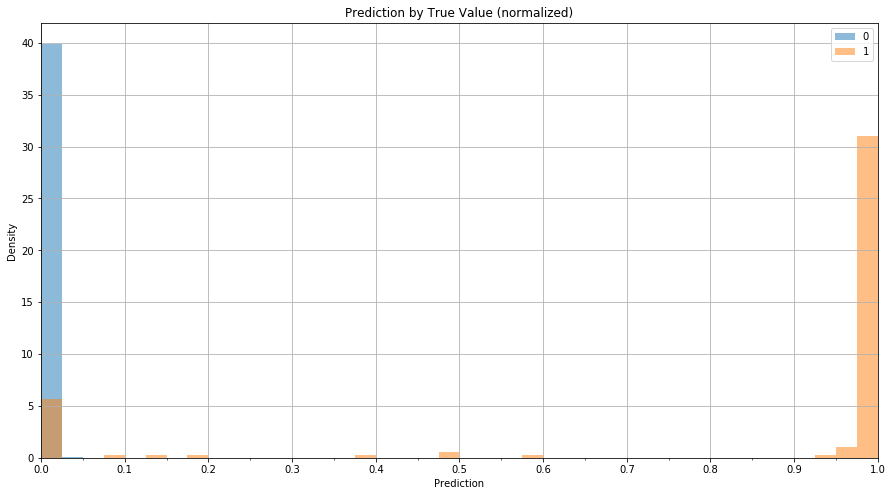

In [14]:
_ = predictions_hist(lgbm_y_score, y_test, density=True)

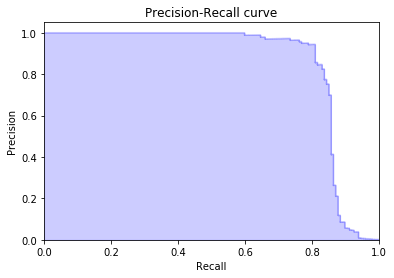

In [15]:
lgbm_results = precision_recall(y_test, lgbm_y_score)

In [16]:
lgbm_report = lgbm_results.sort_values(by='f1_score', ascending=False)

In [17]:
lgbm_report.head(18)

,precision,recall,threshold,f1_score
77869,0.944444,0.809524,0.942382,0.871795
77868,0.937008,0.809524,0.899893,0.868613
77870,0.944000,0.802721,0.955371,0.867647
77867,0.929688,0.809524,0.840916,0.865455
77871,0.943548,0.795918,0.966973,0.863469
77873,0.950820,0.789116,0.969610,0.862454
77866,0.922481,0.809524,0.821845,0.862319
77872,0.943089,0.789116,0.968762,0.859259
77865,0.915385,0.809524,0.809978,0.859206
77874,0.950413,0.782313,0.974833,0.858209


In [18]:
lgbm_threshold = lgbm_report.loc[lgbm_report['f1_score'].idxmax(), 
                                 'threshold']
lgbm_threshold

0.9423816758108632

In [19]:
lgbm_y_pred = lgbm_y_score >= lgbm_threshold

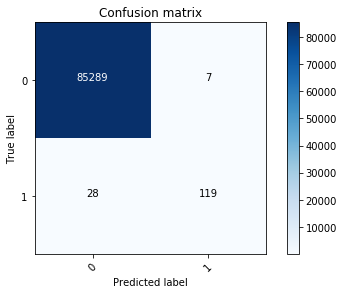

In [20]:
plot_confusion_matrix(y_test, lgbm_y_pred, 
                      class_names=[0, 1])

In [21]:
print(classification_report(y_test, lgbm_y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.94      0.81      0.87       147

avg / total       1.00      1.00      1.00     85443



In [22]:
_ = joblib.dump(lgbm_best, '../models/lgbm.pkl')